In [2]:
"""
I made this code snippet to explicitly respond to the requirments of the MSADS requirements. The code is a simplifed
version of my final project for the course of Python for Data Analysis and Scientific Computing, which built a 
predictive model for diabetes. Please refer to the URL: 
                                    https://github.com/Woodygoodenough/FinalProject 
for the full and runnable version of this project. The entry point of that project is the main file, FinalProject.ipynb. 
And this code snippet is also pushed to the repository, named as CodeSnippetForMSADS.ipynb.
"""
#  1. Import libraries
from collections import namedtuple

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

In [3]:
# 2. Ingest data from csv
df = pd.read_csv("diabetes_prediction_dataset.csv", na_values=["No Info", "Other"], keep_default_na=False) 
# the Na value is designated after initial examination of the dataset
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,NaN,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
# 3. Manage different data types & 7.Write my own function
def _classify_columns(df):
    """
    Automatically classify columns in a DataFrame as categorical or numerical.
    """
    # Initialize
    categorical_cols = []
    numerical_cols = []
    for col in df.columns:
        if df[col].dtype == "object":
            categorical_cols.append(col)
        elif pd.api.types.is_numeric_dtype(df[col]):
            unique_values = df[col].nunique()
            if unique_values < 5: 
                # we consider numerical columns with less than 5 unique values as categorical, which is suitable 
                # in this case, because the values do not have a meaningful order.
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        else:
            categorical_cols.append(col)
    return categorical_cols, numerical_cols
categorical_cols, numerical_cols = _classify_columns(df)
print("categorical features: ", categorical_cols)
print("numerical features: ", numerical_cols)

categorical features:  ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']
numerical features:  ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']


In [5]:
# 6. Wrangle data
# drop rows with missing gender values, because the number is low
df = df.dropna(subset=['gender'])
# impute missing smoking history values with the most frequent value
most_frequent_smoking_history = df['smoking_history'].mode()[0]
df.loc[:, 'smoking_history'] = df.loc[:, 'smoking_history'].fillna(most_frequent_smoking_history)
# encoding former, ever, not current all to ever to simplify the model
df.loc[:, 'smoking_history'] = df.loc[:, 'smoking_history'].replace('former', 'ever')
df.loc[:, 'smoking_history'] = df.loc[:, 'smoking_history'].replace('not current', 'ever')
# use one hot encoding for smoking history
encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[['smoking_history']])
feature_names = encoder.get_feature_names_out(['smoking_history'])
encoded_df = pd.DataFrame(encoded.toarray(), columns=feature_names)
df = df.drop(columns=['smoking_history']).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

In [6]:
# 4. Use my function for data analysis
# Here we are trying to use PCA to analyze the data, before that we need to normalize the data
def categoricals_encoder(df, CATEGORICALS):
    label_encoder = LabelEncoder()
    df_categoricals = pd.DataFrame(columns=CATEGORICALS, dtype="int32")
    for cat in CATEGORICALS:
        df_categoricals.loc[:, cat] = label_encoder.fit_transform(df.loc[:, cat])
    return df_categoricals

def numericals_scaler(df, NUMERICALS):
    scaler = StandardScaler()
    npa_numericals = scaler.fit_transform(df.loc[:, NUMERICALS])
    df_numericals = pd.DataFrame(npa_numericals, columns=NUMERICALS)
    return df_numericals

def normalize(df):
    # encode both categorical and numerical columns and concatenate them to form a normalized dataframe
    categorical_cols, numerical_cols = _classify_columns(df)
    df_categoricals = categoricals_encoder(df, categorical_cols).reset_index(drop=True)
    df_numericals = numericals_scaler(df, numerical_cols).reset_index(drop=True)
    df_normalized = pd.concat([df_categoricals, df_numericals], axis=1)
    return df_normalized

def pca_analysis(features):    
    cov_matrix = np.cov(features, rowvar=False)
    SVDResult = namedtuple("SVDResult", ["U", "S", "Vt"]) # namedtuple for better readability
    return SVDResult(*np.linalg.svd(cov_matrix))
    

df_normalized = normalize(df)
# drop the target column to only perform pca on features
df_features = df_normalized.drop(columns=['diabetes'])
svd = pca_analysis(df_features)
principal_components = svd.Vt.T # get the principal components, which is the transpose of Vt
explained_variance = svd.S / np.sum(svd.S) # get the explained variance on a percentage basis
X_pca_np = np.dot(df_features, principal_components) # get the principal components scores
X_pca_df = pd.DataFrame(X_pca_np, columns=[f"No_{i+1} Pricinpal Component" for i in range(principal_components.shape[1])]) 
# convert to principal components to dataframe

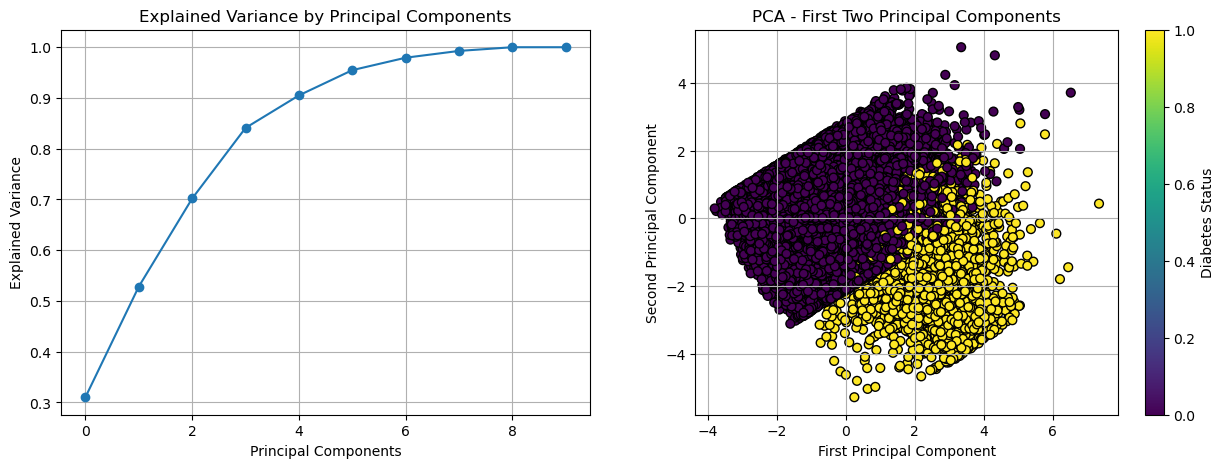

In [7]:
# 5. Visualize data
def get_pca_plots(explained_variance, X_pca_df, target):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # First subplot - Cumulative variance
    ax1.plot(np.cumsum(explained_variance), marker="o")
    ax1.set_xlabel("Principal Components")
    ax1.set_ylabel("Explained Variance")
    ax1.set_title("Explained Variance by Principal Components")
    ax1.grid(True)
    # Second subplot - PCA scatter
    scatter = ax2.scatter(X_pca_df.iloc[:, 0], X_pca_df.iloc[:, 1], c=target, cmap="viridis", edgecolor="k", s=40,)
    ax2.set_xlabel("First Principal Component")
    ax2.set_ylabel("Second Principal Component")
    ax2.set_title("PCA - First Two Principal Components")
    plt.colorbar(scatter, ax=ax2, label="Diabetes Status")
    ax2.grid(True)

    plt.show()

get_pca_plots(explained_variance, X_pca_df, df['diabetes'])
# as shown below, first five principal components explain 90% of the variance
# and the first two principal components are able to separate the two classes well